# Solution for fair price problem assignment

## Input market data

In [1]:
import numpy as np
import collections
import matplotlib.pyplot as plt
import scipy.interpolate

In [2]:
class Bond:
    principal = 0.
    maturity = 1
    coupon = 0.
    fixings = []
    price = 0.
    
    def __init__(self, price, princ, mat, coup, fix):
        self.principal = princ
        self.coupon = coup
        self.fixings = fix
        self.maturity = mat
        self.price = price
        
    def __str__(self):
        return "price=" + str(self.price) + ",principal=" + str(self.principal) + ",maturity=" + str(self.maturity) + "coupon=" + str(self.coupon) + ",fixings=" + str(self.fixings)

In [3]:
class Future:
    settlement_date = 0
    notional = 125000
    strike = 1
    ccy_pair = 'KZEUSD'
    
    def __init__(self, strike, settlement_date):
        self.settlement_date = settlement_date
        self.strike = strike
        
    def __str__(self):
        return "notional=" + str(self.notional) + ",strike=" + str(self.strike) + ",settlement_date=" + str(self.settlement_date) + "ccy_pair=" + str(self.ccy_pair)

In [4]:
bonds = [
Bond(99.8960818102, 100, 1, 0, []),
Bond(984.151376795, 1000, 14, 0, []),
Bond(968.813743758, 1000, 30, 5, [14]),
Bond(951.728786783, 1000, 45, 5, [7, 14]),
Bond(930.971458736, 1000, 60, 5, [1, 30, 45]),
Bond(861.641365245, 1000, 90, 5, [30, 60]),
Bond(4961.08831322, 5000, 7, 0, []),
Bond(4513.12184686, 5000, 70, 15, [14, 45]),
Bond(4066.41561158, 5000, 110, 15, [30, 60, 90]),
Bond(3640.12614792, 5000, 150, 15, [14, 30, 45, 60, 70, 90, 110]),
Bond(3234.95008353, 5000, 180, 15, [30, 60, 90, 120, 150]),
Bond(5470.15644571, 7000, 120, 0, []),
Bond(3425.08246323, 7000, 250, 25, [90, 180]),
Bond(3729.8821621, 7000, 230, 35, [120, 200]),
Bond(4230.57674593, 7000, 200, 45, [60, 120, 180]),
Bond(2805.58732884, 7000, 300, 55, [1, 150, 250]),
Bond(3484.08606273, 10000, 320, 0, []),
Bond(3250.02615097, 10000, 350, 95, [45, 120, 230]),
Bond(2941.86886649, 10000, 360, 15, [150, 250, 350]),
Bond(3136.67468013, 10000, 345, 5, [1, 7, 14, 30, 45, 60, 90, 320]),
Bond(4509.11780809, 10000, 270, 25, [70, 110, 120, 150, 200])
]

futures = [
Future(1.10008682239, 1),
Future(1.09852637731, 7),
Future(1.09803607146, 14),
Future(1.10120481098, 30),
Future(1.11192008225, 60),
Future(1.11436021191, 90),
Future(1.1163015414, 120),
Future(1.11350961507, 150),
Future(1.10642824517, 180),
Future(1.10691160514, 210),
Future(1.10710965335, 240),
Future(1.09612391745, 270),
Future(1.0732310272, 300),
Future(1.04328868705, 330),
Future(1.03244694467, 360)
]

spot = 1.1004

## Bootstrapping USD yield curve from bonds

In [5]:
usd_rates = {}

In [6]:
def yield_usd(zc_bond_price, principal, t):
    return - np.log(zc_bond_price / principal) / t

In [7]:
def to_zero_coupon_price(bond):
    price = bond.price
    for f in bond.fixings:
        price -= bond.coupon * np.exp(- usd_rates[f] * f / 360.)
    return price

### Moving from nearest maturity to farthest

In [8]:
for bond in sorted(bonds, key=lambda x: x.maturity):
    usd_rates[bond.maturity] = yield_usd(to_zero_coupon_price(bond), bond.principal, bond.maturity / 360.)

In [9]:
sorted_usd_rates = collections.OrderedDict(sorted(map(lambda (k,v): (k,v), usd_rates.iteritems())))

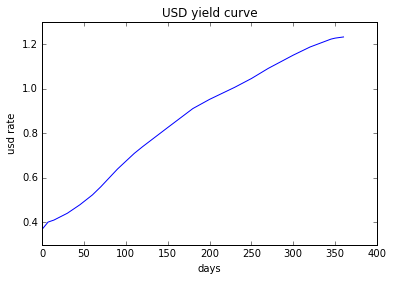

In [10]:
plt.title('USD yield curve')
plt.xlabel('days')
plt.ylabel('usd rate')
plt.plot(sorted_usd_rates.keys(), sorted_usd_rates.values())

### Using linear interpolation for curve

In [11]:
usd_yield_curve = scipy.interpolate.interp1d(sorted_usd_rates.keys(), sorted_usd_rates.values(), kind='linear', assume_sorted=True)

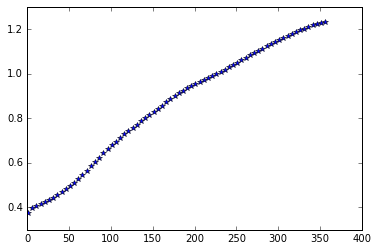

In [12]:
xnew = np.arange(1, 360, 5)
plt.plot(xnew, usd_yield_curve(xnew), '*')

### Futures are used to build EUR yield curve

In [13]:
def future_price(future, spot_price):
    t = future.settlement_date
    return spot_price * np.exp((eur_yield_curve(t) - usd_yield_curve(t)) * t / 360.)

In [14]:
def yield_eur(fut_price, spt_price, t, yield_usd):
    return yield_usd - np.log(fut_price / spt_price) / t

### Again from closest to farthest maturity

In [15]:
eur_rates = {}
for future in sorted(futures, key=lambda x: x.settlement_date):
    tenor = future.settlement_date
    eur_rates[tenor] =  yield_eur(future.strike, spot, tenor / 360., usd_yield_curve(tenor))

In [16]:
sorted_eur_rates = collections.OrderedDict(sorted(map(lambda (k,v): (k,v), eur_rates.iteritems())))

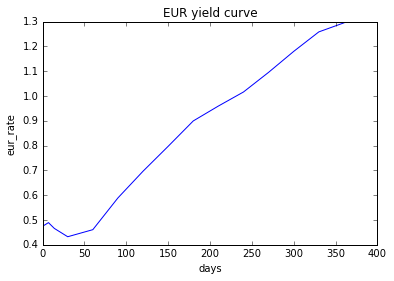

In [17]:
plt.title('EUR yield curve')
plt.xlabel('days')
plt.ylabel('eur_rate')
plt.plot(sorted_eur_rates.keys(), sorted_eur_rates.values())

### Again linear interpolation

In [18]:
eur_yield_curve = scipy.interpolate.interp1d(sorted_eur_rates.keys(), sorted_eur_rates.values(), kind='linear', assume_sorted=True)

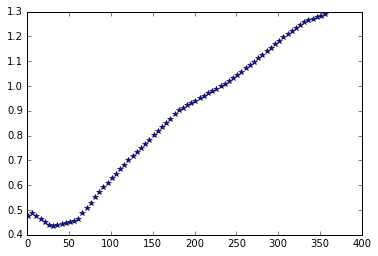

In [19]:
xnew = np.arange(1, 360, 5)
plt.plot(xnew, eur_yield_curve(xnew), '*')

### Determining fair strike

In [20]:
def forward_price(t):
    return spot * np.exp((usd_yield_curve(t) - eur_yield_curve(t)) * t / 360.)

In [21]:
forward_price(180)

1.1064282451700003

### Calculating PV of forward with predefined strike, notional and time to maturity

In [22]:
def forward_pv(n, k, t):
    return n * (spot * np.exp(-eur_yield_curve(t) * t / 360.) - k * np.exp(-usd_yield_curve(t) * t / 360.))

In [23]:
forward_pv(100, 1.1064282451700003, 180)

0.0